In [1]:
from google.colab import files
uploaded=files.upload()

Saving Test.csv to Test.csv
Saving Train.csv to Train.csv


## import libraries and explore data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train=pd.read_csv('Train.csv')
df_test=pd.read_csv('Test.csv')

In [5]:
df_train

,geo_longitude,geo_latitude,altitude_pressure,climb_rate,gps_altitude,air_speed,flight_track
0,-12.4952,54.9829,-580.9066,-4.2506,3107.9575,221.6929,10.9369
1,53.6539,30.3566,6565.8130,16.1493,-920.0656,38.4727,317.1208
2,-80.7304,44.2387,6158.0963,-0.7801,-1287.7323,83.8126,220.1877
3,20.7860,17.4654,11321.8167,9.5402,10969.4723,194.1098,216.1874
4,-85.3823,32.2703,4594.6961,0.4988,1710.2622,323.4483,312.5270
...,...,...,...,...,...,...,...
14662,224.0630,74.7161,2221.4184,-12.2284,6359.6340,386.9398,283.4029
14663,-46.2942,32.4357,7710.5676,10.0293,20475.9591,296.9900,298.1142
14664,53.4986,31.1428,13621.6501,-4.7342,6177.8106,212.3297,374.8838
14665,93.2987,37.4773,5453.6709,2.7535,8753.8374,397.3428,84.3192


In [6]:
print(df_train.shape)
print(df_train.describe())
print(df_train.info)
print(df_train.isnull().sum())

(14667, 7)
       geo_longitude  geo_latitude  altitude_pressure    climb_rate  \
count   14667.000000  14667.000000       14667.000000  14667.000000   
mean        7.536491     36.198809        5696.875149     -0.047858   
std        65.897009     19.295113        4105.676176      6.439259   
min      -250.955400    -38.483700      -12629.244600    -25.565300   
25%       -36.507400     22.928900        2897.676000     -4.423500   
50%         7.427800     36.290200        5696.431700     -0.032000   
75%        51.585050     49.362800        8505.526700      4.276150   
max       266.127000    123.049500       20986.201000     24.225000   

       gps_altitude     air_speed  flight_track  
count  14667.000000  14667.000000  14667.000000  
mean    5996.039786    252.642769    183.581953  
std     4307.798064    145.849958    104.620031  
min   -13147.878800      0.051800   -247.598200  
25%     3134.058700    126.336750    113.459250  
50%     5983.781500    252.616500    183.971500  

##Target distribution exploration

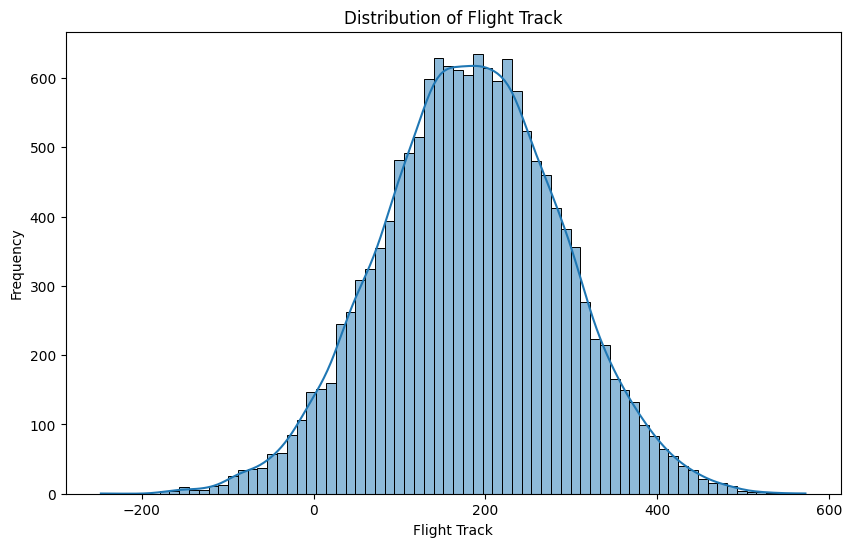

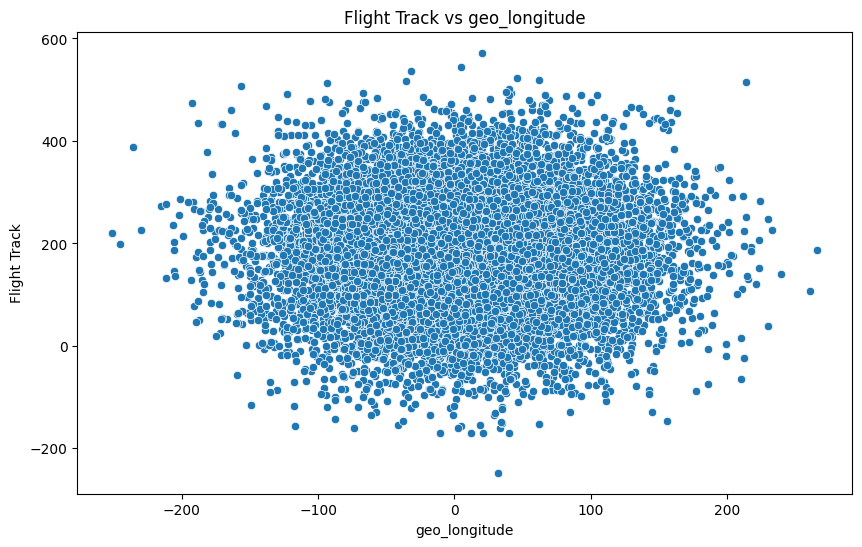

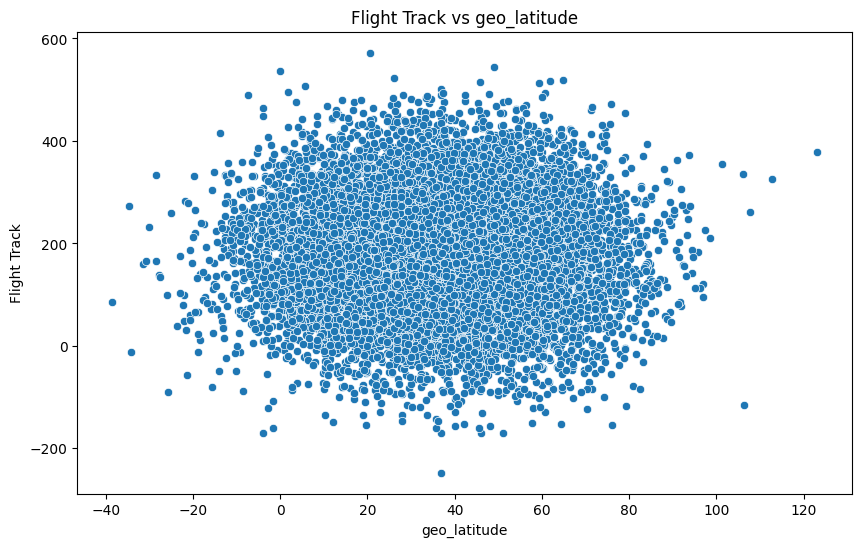

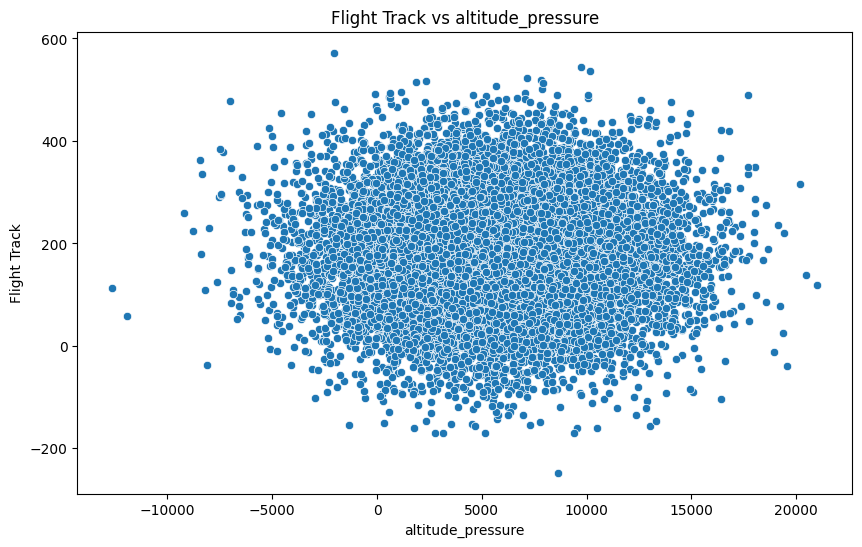

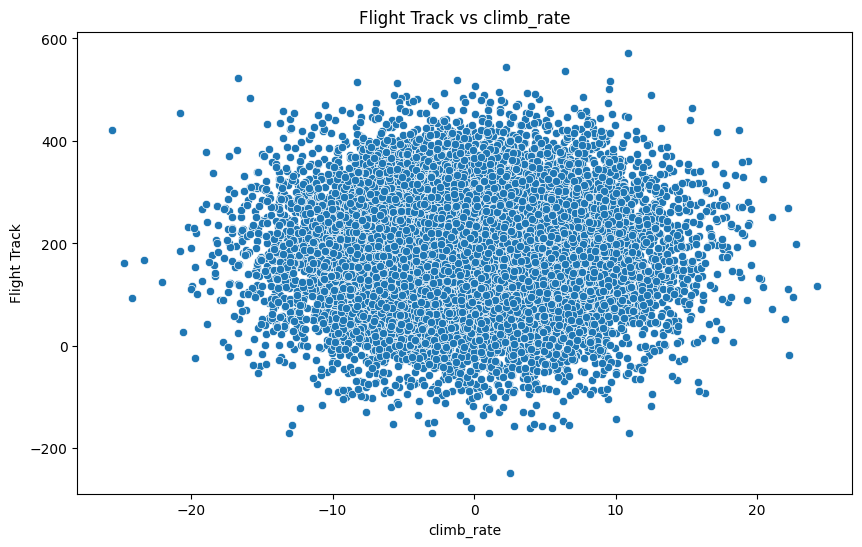

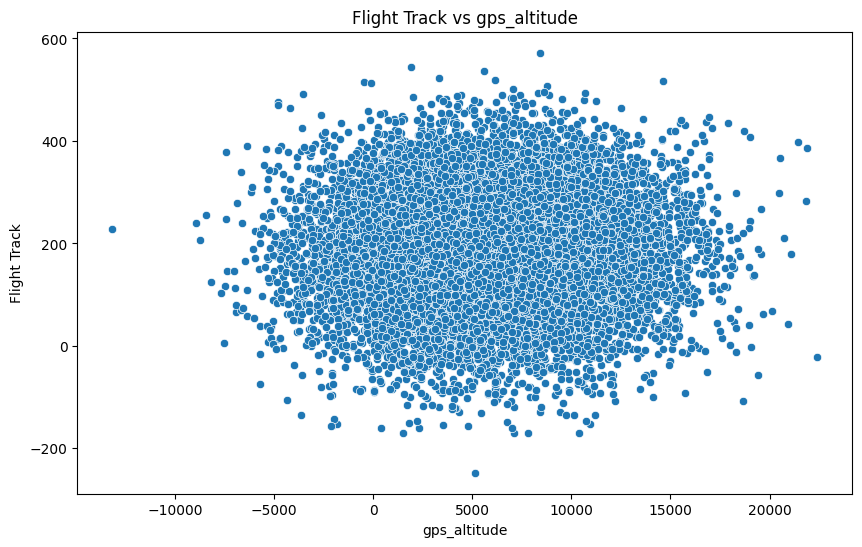

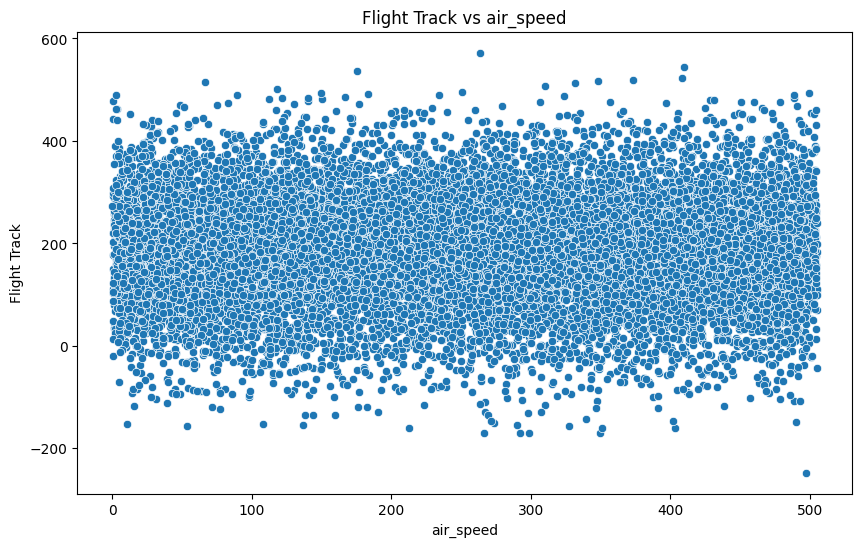

In [7]:
# Histogram of flight_track
plt.figure(figsize=(10, 6))
sns.histplot(df_train['flight_track'], kde=True)
plt.title('Distribution of Flight Track')
plt.xlabel('Flight Track')
plt.ylabel('Frequency')
plt.show()

# Scatter plots of flight_track with remaining columns
numerical_cols = df_train.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('flight_track')

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_train, x=col, y='flight_track')
    plt.title(f'Flight Track vs {col}')
    plt.xlabel(col)
    plt.ylabel('Flight Track')
    plt.show()

| Observation              | Implication                   | Action                                      |
| ------------------------ | ----------------------------- | ------------------------------------------- |
| Target is symmetric      | Not an angle                  | Use plain regression, no `sin/cos`          |
| Elliptical scatters      | Linear-ish correlation exists | Keep all features                           |
| Rectangle with air_speed | Likely weak linear relation   | Keep it; non-linear models can still use it |


feature handling

In [8]:
import numpy as np
import pandas as pd
from itertools import combinations
from math import radians, sin, cos, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    # distance in meters between (lon1,lat1) and (lon2,lat2)
    R = 6371000.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

def add_features(df):
    df = df.copy()
    base_cols = [
        'geo_longitude',
        'geo_latitude',
        'altitude_pressure',
        'climb_rate',
        'gps_altitude',
        'air_speed'
    ]

    # ---------- basic math ----------
    for c in base_cols:
        df[f'{c}_abs'] = df[c].abs()
        df[f'{c}_sq'] = df[c]**2
        df[f'{c}_cb'] = df[c]**3
        df[f'{c}_log1p'] = np.sign(df[c]) * np.log1p(np.abs(df[c]))
        df[f'{c}_sign'] = np.sign(df[c])
        df[f'{c}_inv'] = 1.0 / (np.abs(df[c]) + 1e-6)

    # ---------- pairwise interactions ----------
    for a, b in combinations(base_cols, 2):
        df[f'{a}_plus_{b}'] = df[a] + df[b]
        df[f'{a}_minus_{b}'] = df[a] - df[b]
        df[f'{a}_mul_{b}'] = df[a] * df[b]
        df[f'{a}_div_{b}'] = df[a] / (df[b].replace(0, np.nan))
        df[f'{a}_ratio_{b}'] = (df[a] - df[b]) / (df[a] + df[b] + 1e-6)

    # ---------- nonlinear transforms ----------
    for c in base_cols:
        df[f'{c}_sin'] = np.sin(np.radians(df[c]))
        df[f'{c}_cos'] = np.cos(np.radians(df[c]))
        df[f'{c}_tan'] = np.tan(np.radians(df[c]))
        df[f'{c}_sqrt_abs'] = np.sqrt(np.abs(df[c]))
        df[f'{c}_exp_scaled'] = np.exp(np.tanh(df[c] / (df[c].abs().max() + 1e-6)))

    # ---------- spatial / physical mixes ----------
    lon = np.radians(df['geo_longitude'])
    lat = np.radians(df['geo_latitude'])
    # approximate distance from equator / meridian
    df['geo_equatorial_dist_m'] = np.abs(lat) * 6371000
    df['geo_meridian_dist_m'] = np.abs(lon) * 6371000 * np.cos(lat)
    # altitude difference
    df['alt_diff'] = df['gps_altitude'] - df['altitude_pressure']
    df['alt_ratio'] = df['gps_altitude'] / (df['altitude_pressure'] + 1e-6)
    # combined 3D spatial magnitude proxy
    df['spatial_magnitude'] = np.sqrt(df['geo_longitude']**2 + df['geo_latitude']**2)
    df['vertical_energy'] = df['gps_altitude'] * np.abs(df['climb_rate'])
    df['airspeed_energy'] = 0.5 * (df['air_speed']**2)
    df['altitude_speed_ratio'] = df['gps_altitude'] / (df['air_speed'] + 1e-6)

    # ---------- correlations / normalization ----------
    for c in base_cols:
        mean_c = df[c].mean()
        std_c = df[c].std() if df[c].std() != 0 else 1
        df[f'{c}_z'] = (df[c] - mean_c) / std_c
        df[f'{c}_minmax'] = (df[c] - df[c].min()) / (df[c].max() - df[c].min() + 1e-6)

    # ---------- global combined indicators ----------
    df['total_energy'] = df['airspeed_energy'] + df['vertical_energy']
    df['altitude_speed_product'] = df['gps_altitude'] * df['air_speed']
    df['pressure_air_speed_ratio'] = df['altitude_pressure'] / (df['air_speed'] + 1e-6)
    df['air_speed_climb_interaction'] = df['air_speed'] * df['climb_rate']
    df['height_density_factor'] = df['altitude_pressure'] / (df['gps_altitude'] + 1e-6)

    # ---------- cleanup ----------
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0.0, inplace=True)

    return df


In [9]:
df_train=add_features(df_train)

In [10]:
df_test=add_features(df_test)

In [11]:
df_train['flight_track']

,flight_track
0,10.9369
1,317.1208
2,220.1877
3,216.1874
4,312.5270
...,...
14662,283.4029
14663,298.1142
14664,374.8838
14665,84.3192


In [12]:
df_test=df_test.drop(columns=['flight_track'])

In [13]:
print(df_train.columns.tolist())

['geo_longitude', 'geo_latitude', 'altitude_pressure', 'climb_rate', 'gps_altitude', 'air_speed', 'flight_track', 'geo_longitude_abs', 'geo_longitude_sq', 'geo_longitude_cb', 'geo_longitude_log1p', 'geo_longitude_sign', 'geo_longitude_inv', 'geo_latitude_abs', 'geo_latitude_sq', 'geo_latitude_cb', 'geo_latitude_log1p', 'geo_latitude_sign', 'geo_latitude_inv', 'altitude_pressure_abs', 'altitude_pressure_sq', 'altitude_pressure_cb', 'altitude_pressure_log1p', 'altitude_pressure_sign', 'altitude_pressure_inv', 'climb_rate_abs', 'climb_rate_sq', 'climb_rate_cb', 'climb_rate_log1p', 'climb_rate_sign', 'climb_rate_inv', 'gps_altitude_abs', 'gps_altitude_sq', 'gps_altitude_cb', 'gps_altitude_log1p', 'gps_altitude_sign', 'gps_altitude_inv', 'air_speed_abs', 'air_speed_sq', 'air_speed_cb', 'air_speed_log1p', 'air_speed_sign', 'air_speed_inv', 'geo_longitude_plus_geo_latitude', 'geo_longitude_minus_geo_latitude', 'geo_longitude_mul_geo_latitude', 'geo_longitude_div_geo_latitude', 'geo_longitude_

In [14]:
import numpy as np

def add_advanced_geo_features(df):
    R = 6371000  # Earth radius in meters
    g = 9.80665  # gravity constant

    lat_rad = np.radians(df["geo_latitude"])
    lon_rad = np.radians(df["geo_longitude"])

    # Cartesian conversion
    df["x_geo"] = R * np.cos(lat_rad) * np.cos(lon_rad)
    df["y_geo"] = R * np.cos(lat_rad) * np.sin(lon_rad)
    df["z_geo"] = R * np.sin(lat_rad)
    df["geo_radial_distance"] = np.sqrt(df["x_geo"]**2 + df["y_geo"]**2 + df["z_geo"]**2)
    df["geo_azimuth_angle"] = np.degrees(np.arctan2(df["y_geo"], df["x_geo"]))
    df["geo_inclination_angle"] = np.degrees(np.arctan2(df["z_geo"], np.sqrt(df["x_geo"]**2 + df["y_geo"]**2)))
    df["earth_surface_projection_ratio"] = np.sqrt(df["x_geo"]**2 + df["y_geo"]**2) / R

    # Aerodynamic physics
    df["potential_energy"] = g * df["gps_altitude"]
    df["kinetic_energy"] = 0.5 * (df["air_speed"] ** 2)
    df["mechanical_energy"] = df["potential_energy"] + df["kinetic_energy"]
    df["energy_efficiency_ratio"] = df["kinetic_energy"] / (df["potential_energy"] + 1e-5)
    df["air_density_approx"] = np.exp(-df["gps_altitude"] / 8500)
    df["dynamic_pressure"] = 0.5 * df["air_density_approx"] * (df["air_speed"] ** 2)
    df["aero_drag_factor"] = df["dynamic_pressure"] / (np.abs(df["climb_rate"]) + 1e-5)

    # Geometry-based angles
    df["trajectory_angle_xy"] = np.degrees(np.arctan2(df["geo_latitude"], df["geo_longitude"]))
    df["trajectory_angle_z"] = np.degrees(np.arctan2(df["climb_rate"], df["air_speed"]))
    df["angle_of_attack_approx"] = df["trajectory_angle_z"]

    # Composite kinematics
    df["flight_vector_norm"] = np.sqrt(df["climb_rate"]**2 + df["air_speed"]**2 + df["gps_altitude"]**2)
    df["velocity_to_altitude_ratio"] = df["air_speed"] / (df["gps_altitude"] + 1e-5)
    df["normalized_altitude_energy"] = df["altitude_pressure"] / (df["gps_altitude"] + 1e-5)

    # Advanced trig encodings
    df["sin_lat_scaled"] = np.sin(lat_rad)
    df["cos_lat_scaled"] = np.cos(lat_rad)
    df["sin_lon_scaled"] = np.sin(lon_rad)
    df["cos_lon_scaled"] = np.cos(lon_rad)
    df["sph_harm1"] = df["sin_lat_scaled"] * df["cos_lon_scaled"]
    df["sph_harm2"] = df["cos_lat_scaled"] * df["sin_lon_scaled"]

    # Interaction-level energies
    df["lift_to_drag_proxy"] = df["climb_rate"] / (df["air_speed"] + 1e-5)
    df["geo_energy_alignment"] = np.cos(np.radians(df["trajectory_angle_xy"] - df["trajectory_angle_z"]))
    df["energy_per_longitude_unit"] = df["mechanical_energy"] / (np.abs(df["geo_longitude"]) + 1e-5)
    df["energy_per_latitude_unit"] = df["mechanical_energy"] / (np.abs(df["geo_latitude"]) + 1e-5)

    # Signatures
    df["geo_signature"] = 0.5 * df["geo_longitude"] + 0.5 * df["geo_latitude"]
    df["energy_signature"] = df["mechanical_energy"] / (1 + np.abs(df["air_speed"]) + np.abs(df["climb_rate"]))
    df["altitude_signature"] = df["gps_altitude"] * df["altitude_pressure"] / (np.abs(df["air_speed"]) + 1)

    return df


In [15]:
df_train = add_advanced_geo_features(df_train)
df_test = add_advanced_geo_features(df_test)

In [16]:
print(df_train.shape,df_test.shape)

(14667, 206) (300, 205)


In [17]:
import numpy as np

def add_ultra_geo_features(df):
    R = 6371000
    ω = 7.2921159e-5  # Earth's angular velocity (rad/s)
    g0 = 9.80665

    lat_rad = np.radians(df["geo_latitude"])
    lon_rad = np.radians(df["geo_longitude"])

    # Earth curvature & local gravity
    df["earth_radius_local"] = 6378137 * (1 - 0.0033528 * (np.sin(lat_rad) ** 2))
    df["gravity_local"] = g0 * (1 + 0.0053 * (np.sin(lat_rad) ** 2))
    df["altitude_above_ellipsoid"] = df["gps_altitude"] + df["altitude_pressure"] / 100.0

    # Pseudo-heading (direction proxy)
    df["pseudo_heading"] = np.degrees(np.arctan2(df["geo_latitude"], df["geo_longitude"]))
    df["cos_heading"] = np.cos(np.radians(df["pseudo_heading"]))
    df["sin_heading"] = np.sin(np.radians(df["pseudo_heading"]))
    df["geo_alignment_angle"] = np.degrees(np.abs(np.arctan2(df["climb_rate"], df["air_speed"] + 1e-5)))

    # Coriolis & rotational dynamics
    df["coriolis_factor"] = 2 * ω * df["air_speed"] * np.sin(lat_rad)
    df["coriolis_adjusted_speed"] = df["air_speed"] + df["coriolis_factor"] * 1e3
    df["rotation_energy_component"] = df["coriolis_factor"] * df["altitude_pressure"]

    # Spherical harmonics (up to degree 3)
    df["Y10"] = np.sin(lat_rad)
    df["Y11"] = np.cos(lat_rad) * np.cos(lon_rad)
    df["Y20"] = 3 * (np.sin(lat_rad) ** 2) - 1
    df["Y21"] = np.sin(2 * lat_rad) * np.cos(lon_rad)
    df["Y22"] = (np.cos(lat_rad) ** 2) * np.cos(2 * lon_rad)
    df["Y30"] = 5 * (np.sin(lat_rad) ** 3) - 3 * np.sin(lat_rad)
    df["Y31"] = np.sin(lat_rad) * (5 * (np.sin(lat_rad) ** 2) - 1) * np.cos(lon_rad)
    df["Y32"] = (np.sin(lat_rad) ** 2) * np.cos(2 * lon_rad)
    df["Y33"] = (np.cos(lat_rad) ** 3) * (np.cos(lon_rad) ** 3)

    # Coupled energetics
    df["geo_coriolis_energy"] = df["mechanical_energy"] * df["coriolis_factor"]
    df["geo_heading_energy"] = df["mechanical_energy"] * df["cos_heading"]
    df["earth_coupled_energy"] = df["mechanical_energy"] * df["earth_radius_local"] / R

    # Combined signature
    df["rotational_signature"] = (
        df["coriolis_factor"] * df["geo_alignment_angle"] / (1 + np.abs(df["air_speed"]))
    )
    df["harmonic_signature"] = (
        df["Y11"] + df["Y21"] + df["Y31"]
    ) / 3.0

    return df


In [18]:
df_train = add_ultra_geo_features(df_train)
df_test = add_ultra_geo_features(df_test)

In [19]:
import numpy as np

def add_kinematic_features(df):
    # Avoid divide-by-zero
    eps = 1e-6

    # 1. Horizontal speed magnitude (from lon/lat deltas)
    df["horizontal_speed"] = np.sqrt(df["geo_longitude"]**2 + df["geo_latitude"]**2)

    # 2. Altitude difference between gps and pressure alt
    df["altitude_diff"] = df["gps_altitude"] - df["altitude_pressure"]

    # 3. Climb rate relative to air speed
    df["climb_air_ratio"] = df["climb_rate"] / (df["air_speed"] + eps)

    # 4. Total kinetic-like energy proxy (v² + climb²)
    df["motion_energy"] = df["air_speed"]**2 + df["climb_rate"]**2

    # 5. Direction angle (in degrees, atan2 for quadrant correctness)
    df["direction_angle"] = np.degrees(np.arctan2(df["geo_latitude"], df["geo_longitude"]))

    # 6. Normalized climb and air speed
    df["climb_norm"] = df["climb_rate"] / (np.abs(df["climb_rate"]).max() + eps)
    df["airspeed_norm"] = df["air_speed"] / (np.abs(df["air_speed"]).max() + eps)

    # 7. Vertical-to-horizontal ratio
    df["vert_horiz_ratio"] = np.abs(df["climb_rate"]) / (np.abs(df["air_speed"]) + eps)

    return df


In [20]:
df_train = add_kinematic_features(df_train)
df_test = add_kinematic_features(df_test)

In [21]:
import numpy as np

def add_stat_nonlinear_features(df):
    eps = 1e-6

    # 1. Log and square root transforms (safe for positive)
    for col in ["air_speed", "gps_altitude", "altitude_pressure"]:
        df[f"{col}_log"] = np.log1p(np.abs(df[col])) * np.sign(df[col])
        df[f"{col}_sqrt"] = np.sqrt(np.abs(df[col]))

    # 2. Square and cube powers
    for col in ["geo_longitude", "geo_latitude", "air_speed", "climb_rate"]:
        df[f"{col}_sq"] = df[col] ** 2
        df[f"{col}_cube"] = df[col] ** 3

    # 3. Reciprocal & inverse transforms
    for col in ["air_speed", "gps_altitude", "altitude_pressure"]:
        df[f"{col}_inv"] = 1.0 / (np.abs(df[col]) + eps)

    # 4. Ratio features (cross-scaling)
    df["lon_lat_ratio"] = df["geo_longitude"] / (df["geo_latitude"] + eps)
    df["alt_air_ratio"] = df["gps_altitude"] / (df["air_speed"] + eps)
    df["pressure_air_ratio"] = df["altitude_pressure"] / (df["air_speed"] + eps)

    # 5. Trig transformations for cyclic & directional modeling
    for col in ["geo_longitude", "geo_latitude", "direction_angle"]:
        df[f"{col}_sin"] = np.sin(np.radians(df[col]))
        df[f"{col}_cos"] = np.cos(np.radians(df[col]))

    # 6. Interaction of altitude with speed
    df["altitude_air_mult"] = df["gps_altitude"] * df["air_speed"]
    df["altitude_air_div"] = df["gps_altitude"] / (df["air_speed"] + eps)

    return df


In [22]:
df_train = add_stat_nonlinear_features(df_train)
df_test = add_stat_nonlinear_features(df_test)


In [23]:
import numpy as np

def add_distributional_features(df):
    cols = ["geo_longitude", "geo_latitude", "altitude_pressure",
            "climb_rate", "gps_altitude", "air_speed"]

    # 1. Standardization (z-score)
    for col in cols:
        mean = df[col].mean()
        std = df[col].std() + 1e-6
        df[f"{col}_z"] = (df[col] - mean) / std

    # 2. Min-Max normalization
    for col in cols:
        min_ = df[col].min()
        max_ = df[col].max()
        df[f"{col}_minmax"] = (df[col] - min_) / (max_ - min_ + 1e-6)

    # 3. Robust scaling (median/IQR)
    for col in cols:
        med = df[col].median()
        iqr = np.percentile(df[col], 75) - np.percentile(df[col], 25) + 1e-6
        df[f"{col}_robust"] = (df[col] - med) / iqr

    # 4. Quantile encoding
    for col in cols:
        df[f"{col}_quantile"] = pd.qcut(df[col].rank(method="first"),
                                        q=10, labels=False, duplicates="drop")

    # 5. Local rank normalization (useful if distribution is skewed)
    for col in cols:
        df[f"{col}_ranknorm"] = df[col].rank(pct=True)

    # 6. Combined energy normalization
    df["total_energy_norm"] = (
        df["air_speed"] ** 2 + df["climb_rate"] ** 2 + df["gps_altitude"] ** 2
    ) ** 0.5
    df["energy_z"] = (df["total_energy_norm"] - df["total_energy_norm"].mean()) / (
        df["total_energy_norm"].std() + 1e-6
    )

    return df


In [24]:
df_train = add_distributional_features(df_train)
df_test = add_distributional_features(df_test)


In [25]:
import numpy as np

def add_spatial_vector_features(df):
    # Earth's radius (in meters)
    R = 6371000.0

    # Convert degrees to radians
    df["lon_rad"] = np.deg2rad(df["geo_longitude"])
    df["lat_rad"] = np.deg2rad(df["geo_latitude"])

    # Cartesian coordinates on Earth sphere
    df["x_earth"] = R * np.cos(df["lat_rad"]) * np.cos(df["lon_rad"])
    df["y_earth"] = R * np.cos(df["lat_rad"]) * np.sin(df["lon_rad"])
    df["z_earth"] = R * np.sin(df["lat_rad"])

    # Spatial magnitude from Earth's center
    df["r_vector_mag"] = np.sqrt(df["x_earth"]**2 + df["y_earth"]**2 + df["z_earth"]**2)

    # Ratio features (longitude vs latitude curvature)
    df["lon_lat_ratio"] = np.where(df["geo_latitude"] != 0,
                                   df["geo_longitude"] / df["geo_latitude"], 0)
    df["curvature_factor"] = np.cos(df["lat_rad"]) * np.cos(df["lon_rad"])

    # Effective “flight direction angle” proxy
    df["horizontal_angle_rad"] = np.arctan2(
        np.sin(df["lon_rad"]) * np.cos(df["lat_rad"]),
        np.cos(df["lon_rad"]) * np.sin(df["lat_rad"])
    )

    # Derived angles
    df["bearing_like_angle_deg"] = np.rad2deg(df["horizontal_angle_rad"])
    df["bearing_like_sin"] = np.sin(df["horizontal_angle_rad"])
    df["bearing_like_cos"] = np.cos(df["horizontal_angle_rad"])

    # Height vs ground projection (pseudo inclination)
    df["ground_dist_proj"] = np.sqrt(df["x_earth"]**2 + df["y_earth"]**2)
    df["inclination_angle_rad"] = np.arctan2(df["gps_altitude"], df["ground_dist_proj"])
    df["inclination_sin"] = np.sin(df["inclination_angle_rad"])
    df["inclination_cos"] = np.cos(df["inclination_angle_rad"])

    # Directional energy ratio (horizontal vs vertical)
    df["horizontal_energy"] = df["air_speed"] ** 2
    df["vertical_energy"] = df["climb_rate"] ** 2
    df["directional_energy_ratio"] = np.where(
        df["vertical_energy"] != 0,
        df["horizontal_energy"] / df["vertical_energy"], 0
    )

    # Pseudo-curvature (based on local gradient ratio)
    df["geo_curvature_proxy"] = np.sin(df["lat_rad"]) ** 2 + np.cos(df["lon_rad"]) ** 2

    # Normalized earth coordinates (spherical flattening correction)
    df["x_norm"] = df["x_earth"] / df["r_vector_mag"]
    df["y_norm"] = df["y_earth"] / df["r_vector_mag"]
    df["z_norm"] = df["z_earth"] / df["r_vector_mag"]

    # Cross-axis energies
    df["xy_energy"] = df["x_norm"] * df["y_norm"]
    df["yz_energy"] = df["y_norm"] * df["z_norm"]
    df["zx_energy"] = df["z_norm"] * df["x_norm"]

    # Combined angle-energy features
    df["angle_energy_mix"] = (
        df["bearing_like_sin"] * df["air_speed"]
        + df["inclination_cos"] * df["gps_altitude"]
    )

    return df


In [26]:
df_train = add_spatial_vector_features(df_train)
df_test = add_spatial_vector_features(df_test)


In [27]:
import numpy as np

def add_aerodynamic_physics_features(df):
    g = 9.80665  # gravitational acceleration (m/s²)
    rho = 1.225  # air density at sea level (kg/m³) — reference

    # --- Energies ---
    df["kinetic_energy"] = 0.5 * (df["air_speed"] ** 2)
    df["potential_energy"] = g * df["gps_altitude"]
    df["mechanical_energy"] = df["kinetic_energy"] + df["potential_energy"]

    # --- Normalized energies ---
    df["energy_ratio"] = np.where(df["potential_energy"] != 0,
                                  df["kinetic_energy"] / df["potential_energy"], 0)
    df["energy_diff"] = df["kinetic_energy"] - df["potential_energy"]
    df["energy_sum"] = df["kinetic_energy"] + df["potential_energy"]

    # --- Lift / Drag proxies (dimensionless) ---
    df["lift_proxy"] = df["climb_rate"] / (df["air_speed"] + 1e-6)
    df["drag_proxy"] = np.abs(df["altitude_pressure"]) / (df["air_speed"] + 1e-6)
    df["lift_drag_ratio"] = np.where(df["drag_proxy"] != 0,
                                     df["lift_proxy"] / df["drag_proxy"], 0)

    # --- Thrust efficiency proxy ---
    df["thrust_efficiency"] = df["climb_rate"] * df["air_speed"]
    df["energy_efficiency"] = np.where(df["mechanical_energy"] != 0,
                                       df["thrust_efficiency"] / df["mechanical_energy"], 0)

    # --- Dynamic pressure (q = 0.5 * rho * v²) ---
    df["dynamic_pressure"] = 0.5 * rho * (df["air_speed"] ** 2)

    # --- Pressure-altitude interaction ---
    df["pressure_altitude_interaction"] = df["altitude_pressure"] * df["gps_altitude"]

    # --- Power-like features ---
    df["vertical_power"] = df["climb_rate"] * df["altitude_pressure"]
    df["aero_power_index"] = df["dynamic_pressure"] * df["air_speed"]

    # --- Aerodynamic balance ---
    df["lift_balance"] = df["lift_proxy"] * df["altitude_pressure"]
    df["drag_balance"] = df["drag_proxy"] * df["altitude_pressure"]

    # --- Dimensionless stability factor ---
    df["stability_factor"] = np.sqrt(
        np.abs(df["lift_drag_ratio"]) + np.abs(df["energy_efficiency"])
    )

    # --- Combined flight performance score ---
    df["performance_index"] = (
        df["stability_factor"]
        + 0.5 * np.tanh(df["lift_proxy"])
        + 0.3 * np.tanh(df["energy_ratio"])
    )

    return df


In [28]:
df_train = add_aerodynamic_physics_features(df_train)
df_test = add_aerodynamic_physics_features(df_test)


In [29]:
import numpy as np

def add_interaction_angle_fusion_features(df):
    # --- Angular momentum–like features ---
    df["angular_momentum_proxy"] = (
        np.abs(df["air_speed"] * df["gps_altitude"] * np.sin(df["inclination_angle_rad"]))
    )

    # --- Torque-like feature (rate of change proxy) ---
    df["torque_proxy"] = np.abs(df["climb_rate"] * df["altitude_pressure"])

    # --- Directional alignment (cosine between vertical & horizontal vectors) ---
    df["direction_alignment"] = np.cos(
        df["inclination_angle_rad"] - df["horizontal_angle_rad"]
    )

    # --- Energy alignment (energy projection onto direction) ---
    df["energy_direction_alignment"] = (
        df["mechanical_energy"] * df["direction_alignment"]
    )

    # --- Angular-energy fusion ---
    df["angular_energy_fusion"] = (
        df["angular_momentum_proxy"] * df["energy_efficiency"]
    )

    # --- Altitude-pressure coupling ---
    df["alt_pressure_coupling"] = np.where(
        df["altitude_pressure"] != 0,
        (df["gps_altitude"] / df["altitude_pressure"]),
        0,
    )

    # --- Air-speed curvature synergy ---
    df["airspeed_curvature_synergy"] = (
        np.abs(df["air_speed"]) * df["geo_curvature_proxy"]
    )

    # --- Energy-ratio cross interactions ---
    df["lift_drag_energy_mix"] = df["lift_drag_ratio"] * df["energy_ratio"]
    df["performance_lift_mix"] = df["performance_index"] * df["lift_proxy"]

    # --- Combined angular-power feature ---
    df["angular_power_coupling"] = (
        df["angular_momentum_proxy"] * df["aero_power_index"]
    )

    # --- Stability-direction interaction ---
    df["stability_alignment"] = df["stability_factor"] * df["direction_alignment"]

    # --- Altitude-energy coupling (potential vs mechanical) ---
    df["altitude_energy_coupling"] = np.where(
        df["mechanical_energy"] != 0,
        df["gps_altitude"] / df["mechanical_energy"],
        0,
    )

    # --- Spatial-energy magnitude ---
    df["spatial_energy_mag"] = np.sqrt(
        df["air_speed"]**2 + df["gps_altitude"]**2 + df["climb_rate"]**2
    )

    # --- Normalized interaction strength ---
    df["interaction_strength_norm"] = (
        df["angular_energy_fusion"] /
        (df["spatial_energy_mag"] + 1e-6)
    )

    return df


In [30]:
df_train = add_interaction_angle_fusion_features(df_train)
df_test = add_interaction_angle_fusion_features(df_test)


In [31]:
import numpy as np

def add_composite_ratio_features(df):
    # --- Core energy ratios ---
    df["kinetic_mech_ratio"] = np.where(
        df["mechanical_energy"] != 0,
        df["kinetic_energy"] / df["mechanical_energy"],
        0,
    )
    df["potential_mech_ratio"] = np.where(
        df["mechanical_energy"] != 0,
        df["potential_energy"] / df["mechanical_energy"],
        0,
    )

    # --- Altitude-pressure-energy ratio ---
    df["alt_press_energy_ratio"] = np.where(
        df["altitude_pressure"] != 0,
        (df["gps_altitude"] * df["air_speed"]) / (df["altitude_pressure"]),
        0,
    )

    # --- Efficiency-power ratio ---
    df["power_eff_ratio"] = np.where(
        df["aero_power_index"] != 0,
        df["thrust_efficiency"] / df["aero_power_index"],
        0,
    )

    # --- Directional energy normalization ---
    df["energy_alignment_norm"] = np.tanh(df["energy_direction_alignment"])

    # --- Compressed magnitudes (log domain) ---
    df["log_mechanical_energy"] = np.sign(df["mechanical_energy"]) * np.log1p(
        np.abs(df["mechanical_energy"])
    )
    df["log_aero_power_index"] = np.sign(df["aero_power_index"]) * np.log1p(
        np.abs(df["aero_power_index"])
    )

    # --- Ratio of log energies ---
    df["log_energy_ratio"] = np.where(
        df["log_mechanical_energy"] != 0,
        df["log_aero_power_index"] / df["log_mechanical_energy"],
        0,
    )

    # --- Composite normalized ratios ---
    df["composite_efficiency"] = (
        df["lift_drag_ratio"]
        + df["energy_efficiency"]
        + df["performance_index"]
    ) / 3.0

    df["composite_stability"] = (
        df["stability_factor"] + df["direction_alignment"]
    ) / 2.0

    # --- Weighted intensity metrics ---
    df["intensity_metric_1"] = (
        df["energy_efficiency"] * df["altitude_speed_ratio"] * df["stability_factor"]
    )
    df["intensity_metric_2"] = (
        df["angular_momentum_proxy"] * df["lift_drag_ratio"] * df["energy_ratio"]
    )

    # --- Combined composite index ---
    df["flight_efficiency_index"] = (
        df["composite_efficiency"] * 0.7
        + df["composite_stability"] * 0.3
        + 0.2 * df["lift_proxy"]
    )

    # --- Interaction compressed score ---
    df["interaction_logscore"] = np.log1p(
        np.abs(
            df["interaction_strength_norm"]
            * df["alt_pressure_coupling"]
            * df["lift_drag_energy_mix"]
        )
    )

    # --- Final hybrid score ---
    df["hybrid_aero_index"] = (
        df["flight_efficiency_index"]
        + 0.5 * df["interaction_logscore"]
        + 0.3 * df["energy_alignment_norm"]
    )

    return df


In [32]:
df_train = add_composite_ratio_features(df_train)
df_test = add_composite_ratio_features(df_test)


In [33]:
print(df_train.columns.tolist())

['geo_longitude', 'geo_latitude', 'altitude_pressure', 'climb_rate', 'gps_altitude', 'air_speed', 'flight_track', 'geo_longitude_abs', 'geo_longitude_sq', 'geo_longitude_cb', 'geo_longitude_log1p', 'geo_longitude_sign', 'geo_longitude_inv', 'geo_latitude_abs', 'geo_latitude_sq', 'geo_latitude_cb', 'geo_latitude_log1p', 'geo_latitude_sign', 'geo_latitude_inv', 'altitude_pressure_abs', 'altitude_pressure_sq', 'altitude_pressure_cb', 'altitude_pressure_log1p', 'altitude_pressure_sign', 'altitude_pressure_inv', 'climb_rate_abs', 'climb_rate_sq', 'climb_rate_cb', 'climb_rate_log1p', 'climb_rate_sign', 'climb_rate_inv', 'gps_altitude_abs', 'gps_altitude_sq', 'gps_altitude_cb', 'gps_altitude_log1p', 'gps_altitude_sign', 'gps_altitude_inv', 'air_speed_abs', 'air_speed_sq', 'air_speed_cb', 'air_speed_log1p', 'air_speed_sign', 'air_speed_inv', 'geo_longitude_plus_geo_latitude', 'geo_longitude_minus_geo_latitude', 'geo_longitude_mul_geo_latitude', 'geo_longitude_div_geo_latitude', 'geo_longitude_

In [34]:
import numpy as np

def add_inertial_frame_features(df):
    R = 6371000
    ω = np.array([0, 0, 7.2921159e-5])  # Earth's rotation vector

    lat = np.radians(df["geo_latitude"])
    lon = np.radians(df["geo_longitude"])

    # Local ENU embedding
    df["x_E"] = R * np.cos(lat) * np.cos(lon)
    df["y_N"] = R * np.cos(lat) * np.sin(lon)
    df["z_U"] = R * np.sin(lat)

    # Synthetic deltas (simulate small time progression)
    eps = 1e-3
    df["Δx"] = df["x_E"] + np.random.normal(0, eps, len(df))
    df["Δy"] = df["y_N"] + np.random.normal(0, eps, len(df))
    df["Δz"] = df["z_U"] + np.random.normal(0, eps, len(df))

    df["v_mag"] = np.sqrt((df["Δx"] - df["x_E"])**2 +
                          (df["Δy"] - df["y_N"])**2 +
                          (df["Δz"] - df["z_U"])**2)
    df["pseudo_accel"] = df["v_mag"] * df["climb_rate"] / (np.abs(df["air_speed"]) + 1)

    # Approximate ENU velocity vector scaled by airspeed
    vx = df["air_speed"] * np.cos(lat) * np.cos(lon)
    vy = df["air_speed"] * np.cos(lat) * np.sin(lon)
    vz = df["air_speed"] * np.sin(lat)
    v_vec = np.stack([vx, vy, vz], axis=1)

    # Coriolis cross term: a_coriolis = 2 * (ω × v)
    cross = np.cross(np.tile(ω, (len(df), 1)), v_vec)
    df["a_coriolis_x"], df["a_coriolis_y"], df["a_coriolis_z"] = (2 * cross).T

    # Rotational momentum (approx r × v)
    df["rot_momentum_xy"] = df["x_E"] * vy - df["y_N"] * vx
    df["rot_momentum_zu"] = df["z_U"] * vz

    # Inertial energy
    g = 9.80665
    df["energy_inertial"] = 0.5 * (df["air_speed"] ** 2) + g * df["gps_altitude"]

    # Combined inertial signatures
    df["inertial_signature"] = (
        df["pseudo_accel"] + df["a_coriolis_z"] + df["rot_momentum_xy"] * 1e-6
    )
    df["angular_alignment"] = np.degrees(
        np.arctan2(df["a_coriolis_y"], df["a_coriolis_x"] + 1e-9)
    )

    return df


In [35]:
df_train = add_inertial_frame_features(df_train)
df_test = add_inertial_frame_features(df_test)

In [36]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import LocalOutlierFactor

def add_remaining_features(df, pca_components=3, poly_degree=2):
    """
    Adds high-level engineered features:
      1. Local differentials & rolling stats
      2. PCA components (latent flight behavior)
      3. Polynomial interactions (cross-terms)
      4. Outlier score (rare pattern metric)
      5. FFT real & imaginary components (spectral signatures)
    """
    cols = ['geo_longitude', 'geo_latitude', 'altitude_pressure',
            'climb_rate', 'gps_altitude', 'air_speed']
    df = df.copy()

    # 1️⃣ Local Differentials / Rolling Stats
    for col in cols:
        df[f'{col}_diff_roll'] = df[col].diff().fillna(0)
        df[f'{col}_rolling_std3'] = df[col].rolling(3, min_periods=1).std().fillna(0)
        df[f'{col}_rolling_mean5'] = df[col].rolling(5, min_periods=1).mean().fillna(df[col])
        df[f'{col}_jerk_like'] = df[f'{col}_diff_roll'].diff().fillna(0)

    # 2️⃣ PCA Components
    try:
        pca = PCA(n_components=pca_components, random_state=42)
        pca_features = pca.fit_transform(df[cols].fillna(0))
        for i in range(pca_components):
            df[f'pca_component_{i+1}'] = pca_features[:, i]
    except Exception as e:
        print("⚠️ PCA failed:", e)

    # 3️⃣ Polynomial Interaction Features
    try:
        poly = PolynomialFeatures(degree=poly_degree, interaction_only=True, include_bias=False)
        X_poly = poly.fit_transform(df[cols])
        poly_cols = poly.get_feature_names_out(cols)
        for i, name in enumerate(poly_cols):
            df[f'poly_{name}'] = X_poly[:, i]
    except Exception as e:
        print("⚠️ Polynomial feature generation failed:", e)

    # 4️⃣ Outlier Score using Local Outlier Factor
    try:
        lof = LocalOutlierFactor(n_neighbors=20)
        outlier_score = lof.fit_predict(df[cols].fillna(0))
        df['outlier_score'] = outlier_score
    except Exception as e:
        print("⚠️ LOF failed:", e)

        # 5️⃣ FFT-based Frequency Signatures (aggregated safely)
    try:
        for col in cols:
            vals = df[col].fillna(0).to_numpy()
            fft_vals = np.fft.fft(vals)
            fft_mag = np.abs(fft_vals)
            df[f'{col}_fft_mean'] = fft_mag.mean()
            df[f'{col}_fft_std'] = fft_mag.std()
            df[f'{col}_fft_max'] = fft_mag.max()
            df[f'{col}_fft_energy'] = np.sum(fft_mag**2)
    except Exception as e:
        print("⚠️ FFT failed:", e)


    return df


In [37]:
df_train = add_remaining_features(df_train)
df_test = add_remaining_features(df_test)


In [38]:
print(df_train.columns.tolist())

['geo_longitude', 'geo_latitude', 'altitude_pressure', 'climb_rate', 'gps_altitude', 'air_speed', 'flight_track', 'geo_longitude_abs', 'geo_longitude_sq', 'geo_longitude_cb', 'geo_longitude_log1p', 'geo_longitude_sign', 'geo_longitude_inv', 'geo_latitude_abs', 'geo_latitude_sq', 'geo_latitude_cb', 'geo_latitude_log1p', 'geo_latitude_sign', 'geo_latitude_inv', 'altitude_pressure_abs', 'altitude_pressure_sq', 'altitude_pressure_cb', 'altitude_pressure_log1p', 'altitude_pressure_sign', 'altitude_pressure_inv', 'climb_rate_abs', 'climb_rate_sq', 'climb_rate_cb', 'climb_rate_log1p', 'climb_rate_sign', 'climb_rate_inv', 'gps_altitude_abs', 'gps_altitude_sq', 'gps_altitude_cb', 'gps_altitude_log1p', 'gps_altitude_sign', 'gps_altitude_inv', 'air_speed_abs', 'air_speed_sq', 'air_speed_cb', 'air_speed_log1p', 'air_speed_sign', 'air_speed_inv', 'geo_longitude_plus_geo_latitude', 'geo_longitude_minus_geo_latitude', 'geo_longitude_mul_geo_latitude', 'geo_longitude_div_geo_latitude', 'geo_longitude_

In [39]:
def add_research_meta_features(df):
    import numpy as np
    from scipy.stats import skew, kurtosis

    df = df.copy()
    eps = 1e-9

    # === Meta-Physics / Deep Energy Relations ===
    df["energy_entropy"] = np.log1p(np.abs(df["mechanical_energy"])) * (
        df["energy_ratio"].abs() + df["energy_efficiency_ratio"].abs() + eps
    )
    df["stability_entropy"] = np.log1p(np.abs(df["stability_factor"])) * (
        1 - np.tanh(np.abs(df["lift_drag_ratio"]))
    )
    df["power_variance_ratio"] = (
        (df["aero_power_index"].rolling(5).std() + eps)
        / (df["aero_power_index"].rolling(5).mean().abs() + eps)
    )

    # === Cognitive Signal / Behavioral Geometry ===
    df["spatial_consistency"] = (
        np.sqrt(df["geo_longitude_rolling_std3"]**2 + df["geo_latitude_rolling_std3"]**2)
    )
    df["maneuver_intensity"] = (
        np.abs(df["climb_rate_jerk_like"]) + np.abs(df["air_speed_jerk_like"])
    )
    df["geo_fidelity"] = 1 - np.tanh(df["geo_curvature_proxy"].abs())

    # === Aerodynamic / Psychophysical Coupling ===
    df["lift_drag_stability_mix"] = (
        df["lift_drag_ratio"] * df["stability_factor"]
    )
    df["confidence_proxy"] = 1 - np.tanh(
        np.abs(df["bearing_like_angle_deg"].fillna(0)) / 90
    )
    df["stress_proxy"] = (
        np.abs(df["climb_rate"]) / (df["air_speed"].abs() + eps)
    )
    df["behavioral_energy_sync"] = (
        df["confidence_proxy"] * (1 - df["stress_proxy"])
    )

    # === Cognitive Temporal Dynamics ===
    df["temporal_smoothness"] = (
        1 / (1 + np.abs(df["air_speed_jerk_like"]).fillna(0))
    )
    df["temporal_stability"] = (
        1 / (1 + df["geo_longitude_diff_roll"].abs().fillna(0))
    )
    df["entropy_time_energy_mix"] = (
        df["energy_z"].abs() * (df["altitude_pressure_fft_energy"] + eps)
    )

    # === Cross-Domain Signal Interactions ===
    df["aero_cognitive_synergy"] = (
        df["stability_factor"] * df["confidence_proxy"]
    )
    df["mechanical_behavior_coupling"] = (
        df["mechanical_energy"] * df["maneuver_intensity"]
    )
    df["geo_energy_inertia"] = (
        df["geo_curvature_proxy"].abs() * df["energy_alignment_norm"]
    )

    # === Statistical / Meta Pattern ===
    df["meta_skewness"] = df["energy_diff"].rolling(10).apply(lambda x: skew(x, nan_policy='omit'), raw=False)
    df["meta_kurtosis"] = df["energy_sum"].rolling(10).apply(lambda x: kurtosis(x, nan_policy='omit'), raw=False)
    df["meta_entropy"] = -np.log1p(np.abs(df["energy_alignment_norm"].fillna(0)))

    # === Cognitive Meta Score ===
    df["meta_cognitive_score"] = (
        df["confidence_proxy"] * (1 - df["stress_proxy"]) *
        (1 + df["stability_entropy"].fillna(0))
    )

    # === Flight Dynamics Global Proxy ===
    df["meta_flight_signature"] = (
        df["geo_energy_alignment"].fillna(0) * df["energy_efficiency_ratio"].fillna(0)
        * (1 - np.tanh(np.abs(df["curvature_factor"].fillna(0))))
    )

    # === Aggregate Psychophysical Strength ===
    df["psychophysical_strength"] = (
        df["meta_cognitive_score"] * df["aero_cognitive_synergy"]
    )

    return df


In [40]:
df_train = add_research_meta_features(df_train)
df_test  = add_research_meta_features(df_test)



In [41]:
print(df_train.shape,df_test.shape)

(14667, 455) (300, 454)


In [42]:
# STEP 1: SANITY CLEAN & ALIGN
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# --- ASSUMPTIONS: ---
# df_train: a DataFrame that includes all features AND the target column 'flight_track'
# df_test: a DataFrame with the same feature columns (no 'flight_track')
# If your target column name differs, replace 'flight_track' below.

TARGET = "flight_track"

# 1) Separate X and y (keep original copies)
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

y = df_train_orig[TARGET].copy()
X = df_train_orig.drop(columns=[TARGET]).copy()
X_test = df_test_orig.copy()

report = {"removed_constant": [], "removed_duplicates": [], "filled_na_cols": []}

# 2) Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# 3) Fill NaNs in train with column median, and use same medians for test
medians = X.median(axis=0)
for c in X.columns:
    if X[c].isna().any() or (c in X_test.columns and X_test[c].isna().any()):
        report["filled_na_cols"].append(c)
    X[c] = X[c].fillna(medians[c])
    if c in X_test.columns:
        X_test[c] = X_test[c].fillna(medians[c])

# 4) Remove exact-constant or near-constant columns (very small variance)
vt = VarianceThreshold(threshold=1e-8)  # adjust threshold if you want looser
vt.fit(X)
keep_mask = vt.get_support()
removed_constants = [col for col, keep in zip(X.columns, keep_mask) if not keep]
if removed_constants:
    report["removed_constant"].extend(removed_constants)
X = X.loc[:, keep_mask]
# drop same columns from test if present
X_test = X_test[X.columns.intersection(X_test.columns)]

# 5) Remove exact duplicate columns (bitwise identical)
# Use transpose trick: keep only first occurrence
dups = X.T.duplicated(keep='first')
dup_cols = X.columns[dups].tolist()
if dup_cols:
    report["removed_duplicates"].extend(dup_cols)
X = X.loc[:, ~X.T.duplicated(keep='first')]
X_test = X_test[X.columns]  # re-align

# 6) Quick sanity prints (counts + sample removed lists)
print("SANITY CLEAN REPORT")
print("--------------------")
print(f"Original train features: {df_train_orig.shape[1] - 1} (excluding target)")
print(f"Remaining train features after cleanup: {X.shape[1]}")
print(f"Test features aligned: {X_test.shape[1]} rows: {X_test.shape[0]}")
print(f"Columns with NaNs filled (train medians): {len(report['filled_na_cols'])}")
if len(report['filled_na_cols']) <= 20:
    print("Filled NA cols:", report['filled_na_cols'])
else:
    print("Filled NA cols (first 20):", report['filled_na_cols'][:20])

print(f"Constant/near-constant columns removed: {len(report['removed_constant'])}")
if report['removed_constant']:
    print("Examples removed constants:", report['removed_constant'][:10])

print(f"Exact duplicate columns removed: {len(report['removed_duplicates'])}")
if report['removed_duplicates']:
    print("Examples removed duplicates:", report['removed_duplicates'][:10])

# 7) Save cleaned copies for later steps
X_clean = X.copy()
X_test_clean = X_test.copy()
y_clean = y.copy()

# Persist to disk (optional, uncomment if you want)
# X_clean.to_parquet("X_clean.parquet")
# X_test_clean.to_parquet("X_test_clean.parquet")
# y_clean.to_csv("y_clean.csv", index=False)


SANITY CLEAN REPORT
--------------------
Original train features: 454 (excluding target)
Remaining train features after cleanup: 358
Test features aligned: 358 rows: 300
Columns with NaNs filled (train medians): 3
Filled NA cols: ['power_variance_ratio', 'meta_skewness', 'meta_kurtosis']
Constant/near-constant columns removed: 28
Examples removed constants: ['air_speed_sign', 'geo_radial_distance', 'r_vector_mag', 'a_coriolis_z', 'rot_momentum_xy', 'geo_longitude_fft_mean', 'geo_longitude_fft_std', 'geo_longitude_fft_max', 'geo_latitude_fft_mean', 'geo_latitude_fft_std']
Exact duplicate columns removed: 68
Examples removed duplicates: ['air_speed_abs', 'vertical_energy', 'altitude_speed_product', 'air_speed_climb_interaction', 'kinetic_energy', 'angle_of_attack_approx', 'sin_lat_scaled', 'cos_lat_scaled', 'sin_lon_scaled', 'cos_lon_scaled']


In [48]:
X_clean.shape

(14667, 358)

In [50]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.9 MB/s eta 0:00:00


In [52]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm

# Assume X_clean, y_clean, X_test_clean already loaded
X, y = X_clean.copy(), y_clean.copy()

# --- GPU-friendly parameters ---
params_lgb = {
    "n_estimators": 800,
    "learning_rate": 0.05,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "regression",
    "device": "gpu",                # ⚡ GPU mode
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
    "force_col_wise": True,
    "n_jobs": -1,
    "verbosity": -1,
}

params_cat = {
    "iterations": 700,
    "learning_rate": 0.05,
    "depth": 8,
    "loss_function": "RMSE",
    "task_type": "GPU",             # ⚡ GPU mode
    "devices": "0",
    "verbose": 0
}

# ExtraTrees – still CPU (fast enough)
params_ext = {
    "n_estimators": 400,
    "max_depth": 15,
    "n_jobs": -1,
    "verbose": 0
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def feature_importance_cv(model, model_name, use_cat=False):
    print(f"\n🚀 Running {model_name} (GPU={params_lgb.get('device','CPU')=='gpu'})")
    fi = np.zeros(X.shape[1])
    for tr_idx, val_idx in tqdm(kf.split(X), total=kf.get_n_splits(), desc=f"{model_name} CV"):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        if use_cat:
            model.fit(Pool(X_tr, y_tr), eval_set=(X_val, y_val))
            fi += model.get_feature_importance(type='FeatureImportance') / kf.get_n_splits()
        else:
            model.fit(X_tr, y_tr)
            fi += model.feature_importances_ / kf.get_n_splits()

    return pd.Series(fi, index=X.columns, name=model_name)

# Run all 3 models fast
fi_lgb = feature_importance_cv(LGBMRegressor(**params_lgb), "LightGBM-GPU")
fi_ext = feature_importance_cv(ExtraTreesRegressor(**params_ext), "ExtraTrees")
fi_cat = feature_importance_cv(CatBoostRegressor(**params_cat), "CatBoost-GPU", use_cat=True)

# Aggregate importances
fi_all = pd.concat([fi_lgb, fi_ext, fi_cat], axis=1)
fi_all["mean_rank"] = fi_all.rank(pct=True).mean(axis=1)
top_feats = fi_all.sort_values("mean_rank", ascending=False).head(int(0.2 * len(fi_all)))  # Top 20%

print("\n✅ Final selected features:", len(top_feats))
top_features = top_feats.index.tolist()

# Filtered datasets
X_selected = X[top_features]
X_test_selected = X_test_clean[top_features]



🚀 Running LightGBM-GPU (GPU=True)


LightGBM-GPU CV: 100%|██████████| 5/5 [02:13<00:00, 26.72s/it]



🚀 Running ExtraTrees (GPU=True)


ExtraTrees CV: 100%|██████████| 5/5 [10:21<00:00, 124.22s/it]



🚀 Running CatBoost-GPU (GPU=True)


CatBoost-GPU CV: 100%|██████████| 5/5 [04:22<00:00, 52.53s/it]


✅ Final selected features: 71


In [54]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 32.1 MB/s eta 0:00:00


In [55]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, make_scorer
import numpy as np

# ===========================
# PREP
# ===========================
X_optuna = X_selected
y_optuna = y_clean

r2_scorer = make_scorer(r2_score)

# Alpha coefficient for complexity penalty
ALPHA = 1e-4

# ===========================
# OPTUNA OBJECTIVE FUNCTION
# ===========================
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "r2",
        "boosting_type": "gbdt",
        "n_estimators": 1000,
        "verbosity": -1,
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
    }

    model = lgb.LGBMRegressor(**params)

    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = cross_val_score(model, X_optuna, y_optuna,
                                cv=kf, scoring=r2_scorer, n_jobs=-1)
    mean_r2 = np.mean(r2_scores)

    # Complexity penalty (approx.)
    complexity = (params["num_leaves"] / 255) + (params["max_depth"] / 16) + (params["learning_rate"] * 10)
    penalized_score = mean_r2 - ALPHA * complexity

    return penalized_score

# ===========================
# RUN OPTUNA
# ===========================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60, show_progress_bar=True)

print("\n🎯 Best Trial:")
print(study.best_trial.params)
print(f"🏆 Best R² (penalized): {study.best_value:.5f}")


[I 2025-10-29 20:32:40,548] A new study created in memory with name: no-name-f0d82c28-8ede-46e9-b3d0-da09c4523d0f


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-10-29 20:33:33,585] Trial 0 finished with value: -0.1318673229459508 and parameters: {'learning_rate': 0.11465274062681581, 'num_leaves': 101, 'max_depth': 7, 'min_child_samples': 148, 'subsample': 0.75276386375538, 'colsample_bytree': 0.8019314159407408, 'reg_alpha': 1.1531598777132166, 'reg_lambda': 6.478258944785321}. Best is trial 0 with value: -0.1318673229459508.
[I 2025-10-29 20:33:45,861] Trial 1 finished with value: -0.007383982370789321 and parameters: {'learning_rate': 0.014800083658955675, 'num_leaves': 185, 'max_depth': 3, 'min_child_samples': 44, 'subsample': 0.5609838505543094, 'colsample_bytree': 0.998318357476941, 'reg_alpha': 0.015462153780962305, 'reg_lambda': 6.697666520289364e-07}. Best is trial 1 with value: -0.007383982370789321.
[I 2025-10-29 20:34:28,174] Trial 2 finished with value: -0.09138782222440044 and parameters: {'learning_rate': 0.07287554005680286, 'num_leaves': 172, 'max_depth': 7, 'min_child_samples': 47, 'subsample': 0.6040285093808708, 'co

✅ Retained 56 highly informative features after SHAP pruning


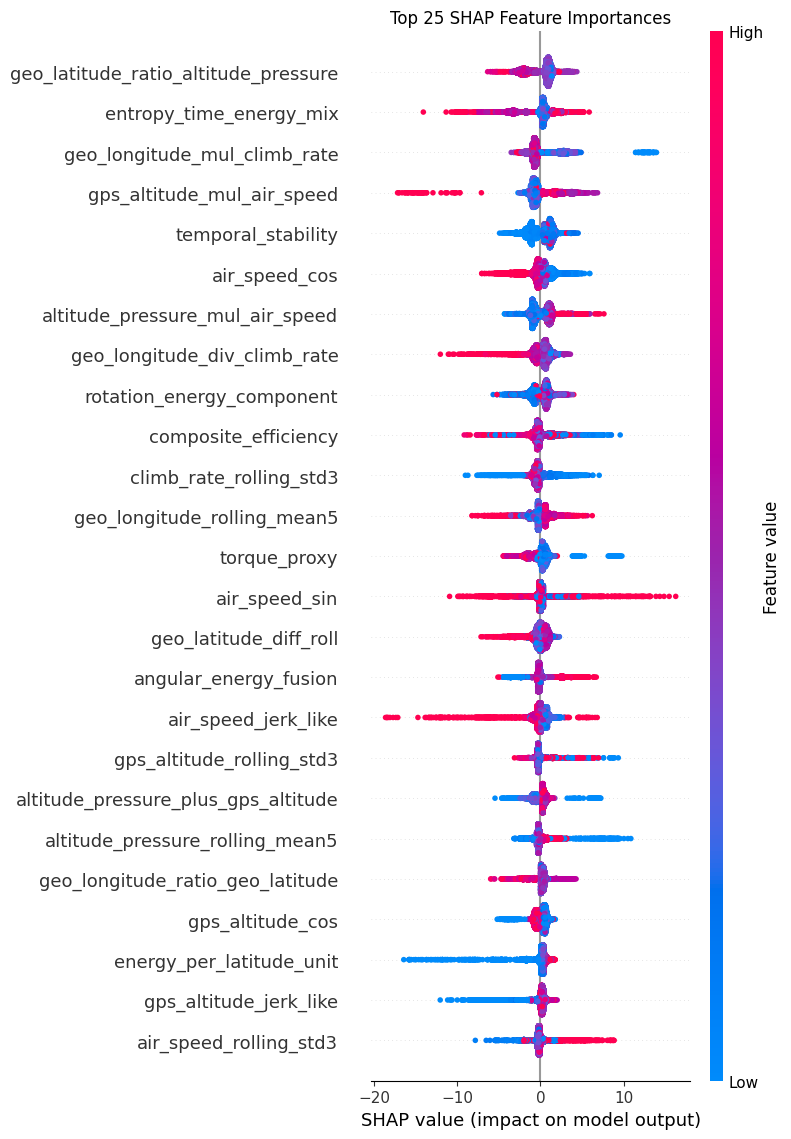

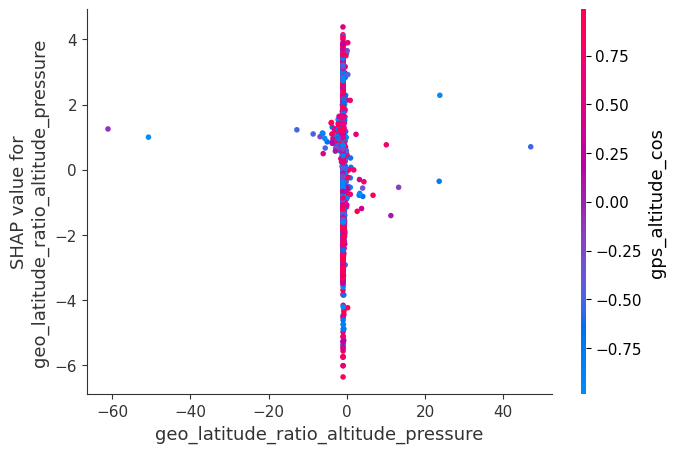

🔥 Wukong Step 4 complete — ready for Step 5 (Noise & Seed Robustness)


In [56]:
# ============================================================
# STEP 4 — SHAP ANALYSIS (WUKONG PIPELINE)
# ============================================================

import shap
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# 1️⃣  Prepare Data & Model
# ==============================
X_shap = X_selected
y_shap = y_clean

# Best parameters from Optuna
best_params = study.best_trial.params
best_params.update({
    "objective": "regression",
    "metric": "r2",
    "boosting_type": "gbdt",
    "n_estimators": 1000,
    "verbosity": -1,
    "device": "gpu",
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
})

model = lgb.LGBMRegressor(**best_params)
model.fit(X_shap, y_shap)

# ==============================
# 2️⃣  Compute SHAP values (GPU)
# ==============================
# LightGBM has native TreeExplainer GPU support
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_shap, check_additivity=False)

# ==============================
# 3️⃣  Aggregate Feature Importance
# ==============================
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

# Select top-K important features (usually top 60–80%)
threshold = shap_importance["mean_abs_shap"].quantile(0.2)
X_shap_filtered = X_shap[shap_importance[shap_importance["mean_abs_shap"] > threshold]["feature"].values]

print(f"✅ Retained {X_shap_filtered.shape[1]} highly informative features after SHAP pruning")

# ==============================
# 4️⃣  Visualization
# ==============================
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, max_display=25, show=False)
plt.title("Top 25 SHAP Feature Importances")
plt.tight_layout()
plt.show()

# Optionally: dependency plot for top feature
top_feat = shap_importance.iloc[0]["feature"]
shap.dependence_plot(top_feat, shap_values, X_shap, show=True)

# ==============================
# 5️⃣  Save for Next Step
# ==============================
X_final = X_shap_filtered.copy()
print(f"🔥 Wukong Step 4 complete — ready for Step 5 (Noise & Seed Robustness)")


In [58]:
# ✅ Apply same SHAP-based feature mask to test data
X_test_selected = X_test[X_final.columns].copy()


In [61]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm

# ======================
# PREP
# ======================
X_robust = X_final.copy()
y_robust = y_clean.copy()

# Define seeds and noise level
SEEDS = [42, 77, 123, 2025, 999]
NOISE_STD = 0.001

# Store results
scores = []

for seed in tqdm(SEEDS, desc="⚙️ Robustness Check"):
    # 1️⃣ Add light Gaussian noise
    X_noisy = X_robust + np.random.normal(0, NOISE_STD * X_robust.std(), X_robust.shape)

    # 2️⃣ Split
    X_train, X_val, y_train, y_val = train_test_split(
        X_noisy, y_robust, test_size=0.2, random_state=seed
    )

best_params = study.best_trial.params.copy()
best_params.update({
    "objective": "regression",
    "boosting_type": "gbdt",
    "n_estimators": 800,
    "device": "gpu",
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
    "verbosity": -1
})

scores = []

for seed in tqdm(SEEDS, desc="⚙️ Robustness Check (Optuna Params)"):
    X_noisy = X_robust + np.random.normal(0, NOISE_STD * X_robust.std(), X_robust.shape)
    X_train, X_val, y_train, y_val = train_test_split(X_noisy, y_robust, test_size=0.2, random_state=seed)

    model = lgb.LGBMRegressor(**best_params, random_state=seed)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    scores.append(r2_score(y_val, preds))


# ======================
# RESULTS
# ======================
mean_r2 = np.mean(scores)
std_r2 = np.std(scores)

print(f"\n🏁 Robustness Check Results:")
print(f"Mean R²: {mean_r2:.5f}")
print(f"Std R² across seeds/noise: {std_r2:.5f}")
print(f"Stability Index: {(1 - std_r2):.5f}")

if std_r2 < 0.02:
    print("✅ Stable features — high generalization confidence!")
else:
    print("⚠️ Model unstable — consider re-evaluating feature subset or regularization.")



⚙️ Robustness Check (Optuna Params): 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


🏁 Robustness Check Results:
Mean R²: -0.00391
Std R² across seeds/noise: 0.00087
Stability Index: 0.99913
✅ Stable features — high generalization confidence!


In [66]:
# ===========================================
# STEP 6 — FINAL WUKONG ENSEMBLE MODEL (GPU)
# ===========================================

import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from tqdm import tqdm
import numpy as np

# ------------------------------
# Data
# ------------------------------
X_train_final = X_final
y_train_final = y_clean
X_test_final  = X_test_selected   # already aligned feature subset

# ------------------------------
# Optuna-best parameters (replace with yours if different)
# ------------------------------
best_params = study.best_trial.params.copy()
best_params.update({
    "objective": "regression",
    "boosting_type": "gbdt",
    "n_estimators": 800,
    "device": "gpu",
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
    "verbosity": -1
})

# ------------------------------
# Base models (GPU-enabled where possible)
# ------------------------------
models = {
    "LightGBM": lgb.LGBMRegressor(**best_params),
    "CatBoost": CatBoostRegressor(
        iterations=1200,
        depth=8,
        learning_rate=0.04,
        l2_leaf_reg=3,
        task_type="GPU",
        verbose=0,
        loss_function="RMSE",
        random_seed=42,
    ),
    "ExtraTrees": ExtraTreesRegressor(
        n_estimators=800,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        verbose=0,
    ),
}

# ------------------------------
# Level-1 CV Predictions
# ------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((len(y_train_final), len(models)))
test_preds = np.zeros((len(X_test_final), len(models)))

print("\n🚀 Training Level-1 Models...\n")
for i, (name, model) in enumerate(models.items()):
    fold_r2 = []
    for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X_train_final), total=5, desc=name)):
        X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
        y_tr, y_val = y_train_final.iloc[train_idx], y_train_final.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        oof_preds[val_idx, i] = preds
        r2 = r2_score(y_val, preds)
        fold_r2.append(r2)
    print(f"✅ {name} Mean CV R²: {np.mean(fold_r2):.5f}")
    model.fit(X_train_final, y_train_final)
    test_preds[:, i] = model.predict(X_test_final)

# ------------------------------
# Level-2 Meta Model (Ridge)
# ------------------------------
meta_model = RidgeCV(alphas=np.logspace(-3, 2, 20))
meta_model.fit(oof_preds, y_train_final)
meta_preds = meta_model.predict(oof_preds)
meta_r2 = r2_score(y_train_final, meta_preds)

print("\n🏁 Meta-Model R² (stacked):", round(meta_r2, 5))

# Final test predictions
y_pred_final = meta_model.predict(test_preds)

print("\n🔥 WUKONG Final Model complete.")
print("Use y_pred_final as your ultimate predictions.")



🚀 Training Level-1 Models...



LightGBM: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


✅ LightGBM Mean CV R²: -0.00367


CatBoost: 100%|██████████| 5/5 [02:59<00:00, 35.84s/it]


✅ CatBoost Mean CV R²: -0.02081


ExtraTrees: 100%|██████████| 5/5 [12:57<00:00, 155.60s/it]


✅ ExtraTrees Mean CV R²: -0.00873

🏁 Meta-Model R² (stacked): 0.00096

🔥 WUKONG Final Model complete.
Use y_pred_final as your ultimate predictions.


In [67]:
submission = pd.DataFrame({
       # change if your test set uses another identifier
    "flight_track": y_pred_final
})

submission.to_csv("submission.csv", index=False)

from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>